In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

warnings.simplefilter("ignore")

In [2]:
## Assign DATA_PATH variable with your path to the csv file for dataset, and ensure we are using the same dataset
DATA_PATH = "../DATA/OCO2_kenya_final_01_01_23.csv"

### Dataset metadata

lat - represents latitude 

lon – represents Longitude

XCO2 (mol CO2/mol dry) – This column is the CO2 concentration column

XCO2PREC (mol CO2/mol dry) – This column represents the precision in the measurement of CO2

Month – month 

Year - Year

DATE – Date 

Population – Population at given latitude and longitude

primary_fuel – Valid for power plant type. Whether it is oil, coal, hydro, wind etc based power plant. 

commissioning_year – Year when particular power plant was established

capacity_mw – Capacity in MW of a given power plant 

city_ascii – City name 

capital – Capital of the city 

city_pop_2022 – city population as of 2022 

month – Month 

brightness - brightness temperature of the fire pixel measured in Kelvin.

Scan – Irrelevant Data 

Track – Irrelevant Data 

bright_t31 – brightness temperature of the fire pixel measured in Kelvin.

frp - fire radiative power in MW (megawatts).

City – City 

State - State

plant_type – whether the plant or factory type is cement based plant or oil refinery or steel plant

longitude – longitude 

latitude – latitude 

In [63]:
df = pd.read_csv(DATA_PATH)
df.head()

,lat,lon,XCO2,XCO2PREC,Month,Year,DATE,primary_fuel,commissioning_year,capacity_mw,plant_type,city_ascii,city_pop_2022,brightness,scan,track,bright_t31,frp,population
0,-5.0,33.75,0.000399,5.011889e-08,1,2015,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-5.0,33.75,0.000398,6.134135e-08,2,2015,2015-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-5.0,33.75,0.000399,3.495060e-08,3,2015,2015-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.0,33.75,0.000397,3.358707e-08,4,2015,2015-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-5.0,33.75,0.000398,3.140227e-08,5,2015,2015-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df["plant_type"].unique()

array([nan, 'Cement ', 'Oil refineries', 'Steel'], dtype=object)

In [65]:
columns = list(df.columns)
print("\n\t\tCOLUMNS IN THE DATASET\n===============================================================\n")
for index, col in enumerate(columns):
    print(col, end="\t    ")
    if (index+1) %5 == 0:
        print("\n")


		COLUMNS IN THE DATASET

lat	    lon	    XCO2	    XCO2PREC	    Month	    

Year	    DATE	    primary_fuel	    commissioning_year	    capacity_mw	    

plant_type	    city_ascii	    city_pop_2022	    brightness	    scan	    

track	    bright_t31	    frp	    population	    

## Renaming columns of the dataframe

In [66]:
# columns selected for modelling
SELECTED_COLUMNS = ["lat", "lon", "XCO2","XCO2PREC", "Month", "Year", "primary_fuel", "commissioning_year", "capacity_mw",
                    "population", "plant_type", "city_pop_2022", "brightness", "scan", "track", "bright_t31", "frp"]

## Dealing with null/missing values

In [67]:
sorted_df = df[SELECTED_COLUMNS].sort_values(by="Year") # sorting data by year

# removing an outlier for 2015 population from 2015728.60 to 48942.63
sorted_df.replace({"population":{2015728.60: 48942.63}}, inplace=True)

In [68]:
len(sorted_df)

28728

In [69]:
sorted_df.isna().sum()

lat                       0
lon                       0
XCO2                      0
XCO2PREC                342
Month                     0
Year                      0
primary_fuel          26064
commissioning_year    26064
capacity_mw           26064
population            11592
plant_type            26208
city_pop_2022         22596
brightness            23345
scan                  23345
track                 23345
bright_t31            23345
frp                   23345
dtype: int64

## Missing values 

Population for 2021 is missing

In [70]:
#dropping records with Population is NAN
indices_to_drop = sorted_df[sorted_df["population"].isna()].index.values
pop_cleaned_df = sorted_df.drop(indices_to_drop, axis=0)

pop_cleaned_df.isna().sum()

lat                       0
lon                       0
XCO2                      0
XCO2PREC                238
Month                     0
Year                      0
primary_fuel          14856
commissioning_year    14856
capacity_mw           14856
population                0
plant_type            14976
city_pop_2022         11880
brightness            12575
scan                  12575
track                 12575
bright_t31            12575
frp                   12575
dtype: int64

##### Filling null/missing values for commissioning year, primary fuel, capacity_mw and power plant type using bfill

In [71]:
FEATURES_FOR_MODELLING = ["Year", "capacity_mw", "plant_type", "primary_fuel", "population", "frp", "XCO2"]

In [72]:
modelling_data = pop_cleaned_df[FEATURES_FOR_MODELLING]
modelling_data.head()

,Year,capacity_mw,plant_type,primary_fuel,population,frp,XCO2
26635,2015,NaN,NaN,NaN,16838.428,NaN,0.000399
26634,2015,NaN,NaN,NaN,16838.428,NaN,0.000399
26633,2015,NaN,NaN,NaN,16838.428,NaN,0.000399
26632,2015,NaN,NaN,NaN,16838.428,NaN,0.000399
26631,2015,NaN,NaN,NaN,16838.428,NaN,0.000400


In [73]:
# cleaning data
modelling_data.fillna(value={"primary_fuel": "NA", "frp": 0.0, "capacity_mw": 0.0, "plant_type": "NA"}, inplace=True)
modelling_data.head()

,Year,capacity_mw,plant_type,primary_fuel,population,frp,XCO2
26635,2015,0.0,NA,NA,16838.428,0.0,0.000399
26634,2015,0.0,NA,NA,16838.428,0.0,0.000399
26633,2015,0.0,NA,NA,16838.428,0.0,0.000399
26632,2015,0.0,NA,NA,16838.428,0.0,0.000399
26631,2015,0.0,NA,NA,16838.428,0.0,0.000400


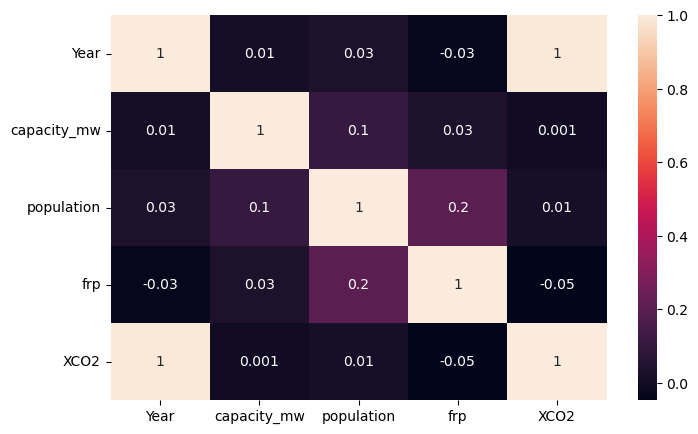

In [74]:
# visualizing the correlation matrix for variable to see how is the relationship among them
plt.figure(figsize=(8, 5))
sns.heatmap(modelling_data.corr(), annot=True, fmt=".1g")
plt.show()

Seems variables have no strong correlation among themselves but the problem also independent variables( lat, lon, Month,Year,population,brightness,bright_t31, frp) have no relavant relationship with the dependent/predicted variable(XCO2)

## Expolaration of the distributions of dataset

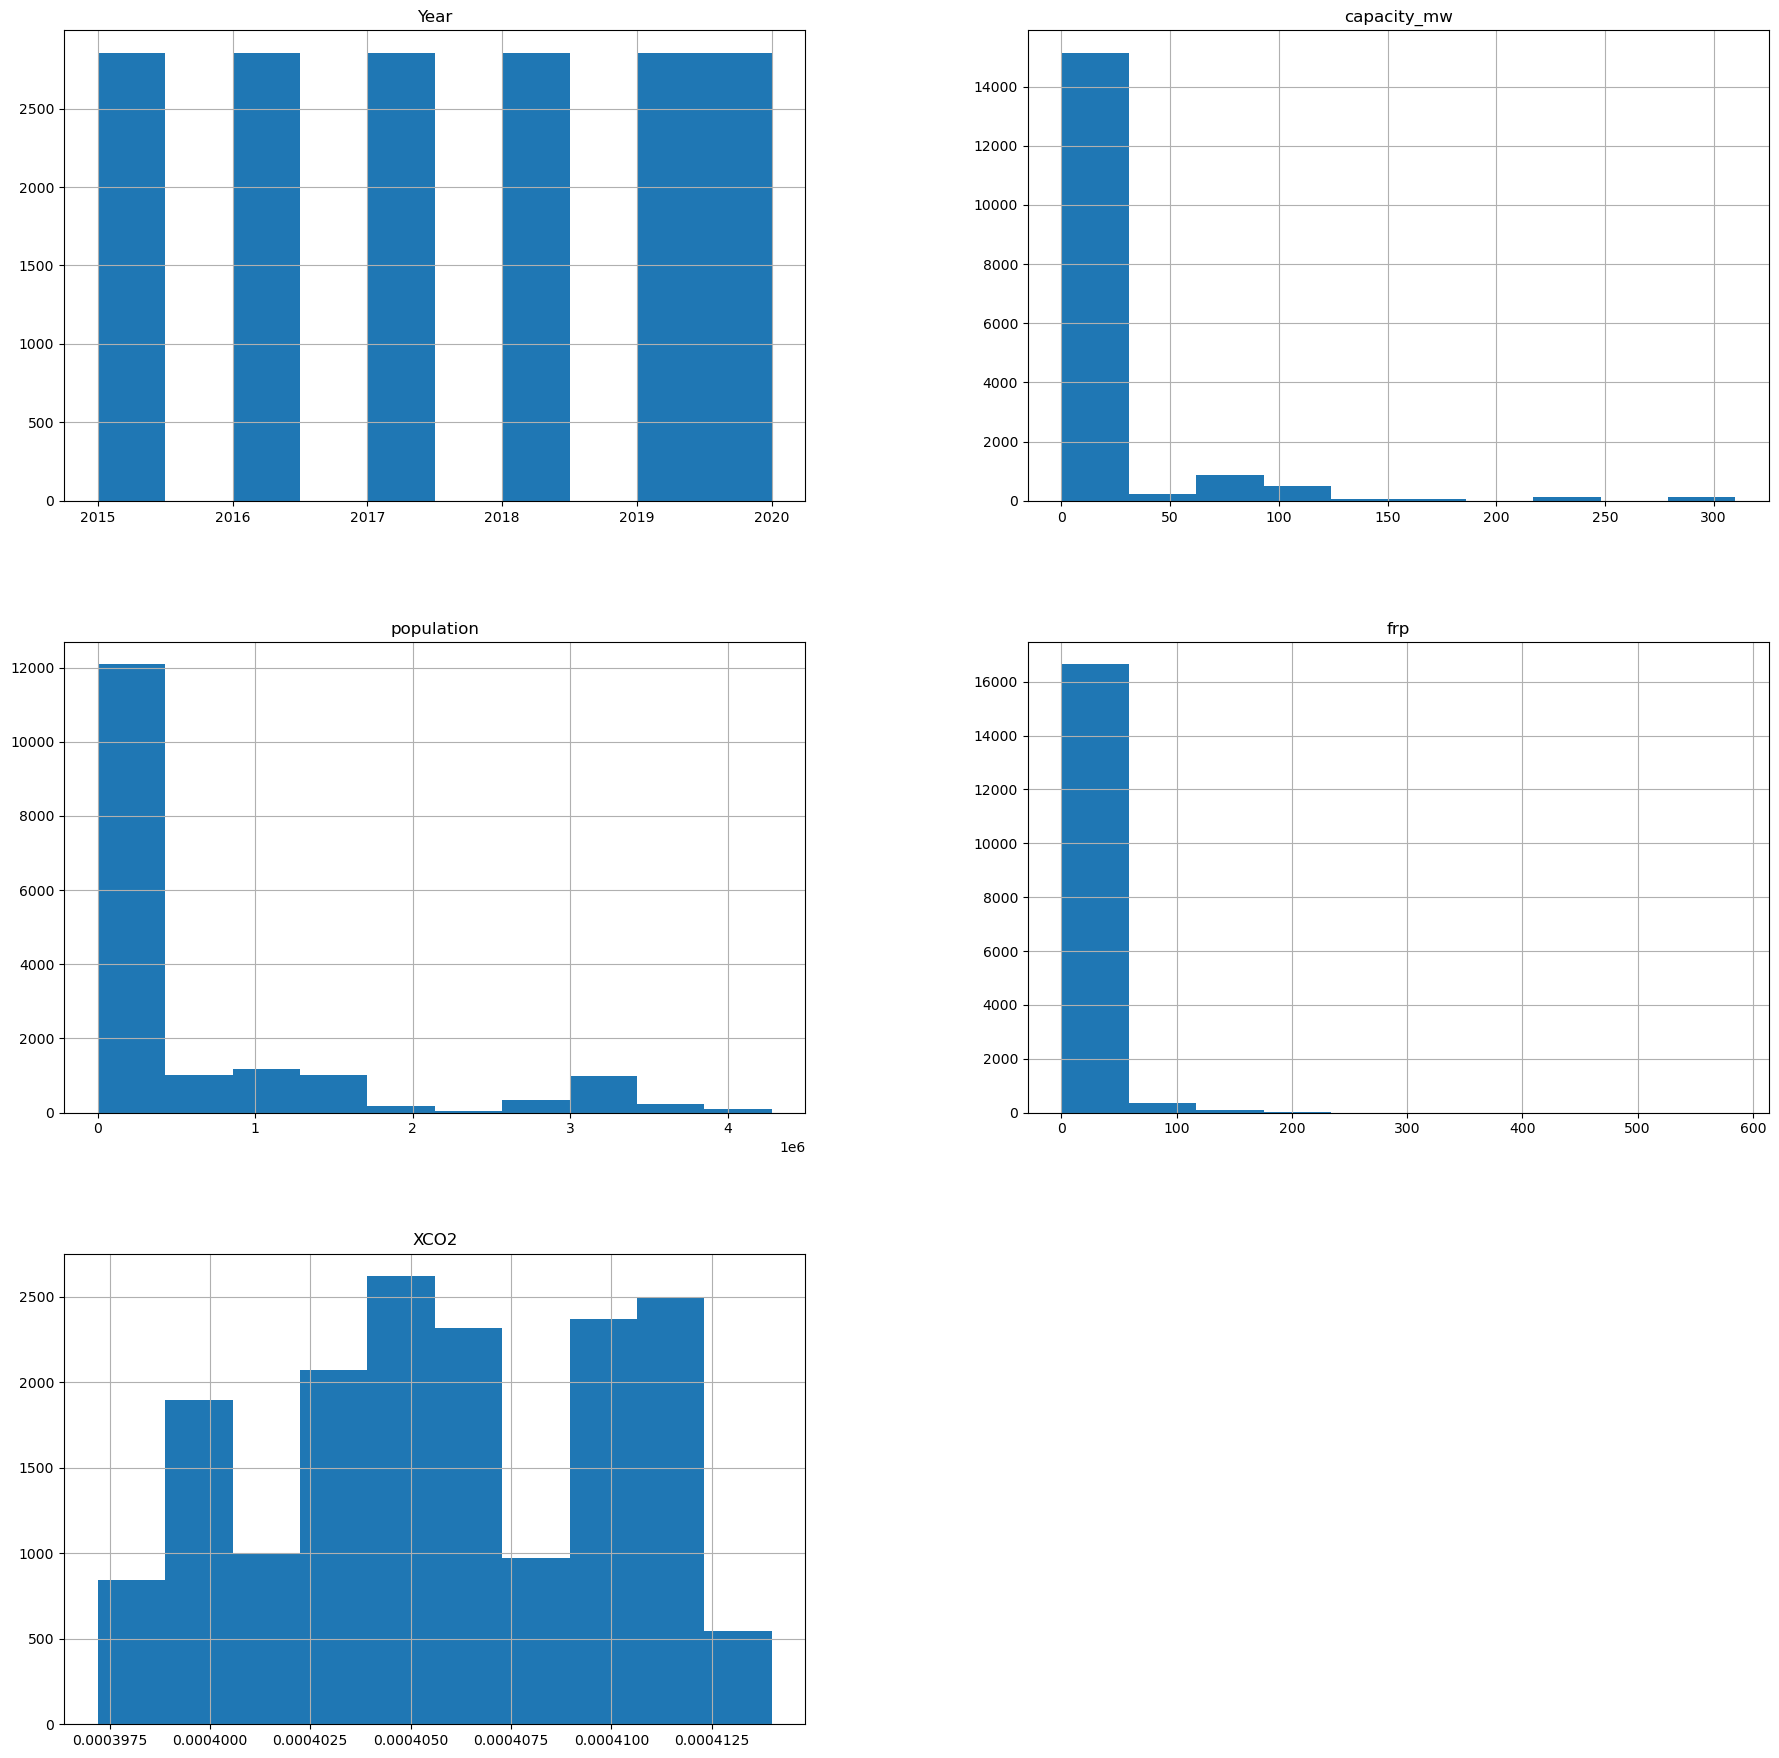

In [75]:
plt.rcParams["figure.figsize"] = (22,22)
modelling_data[FEATURES_FOR_MODELLING].hist()
plt.show()

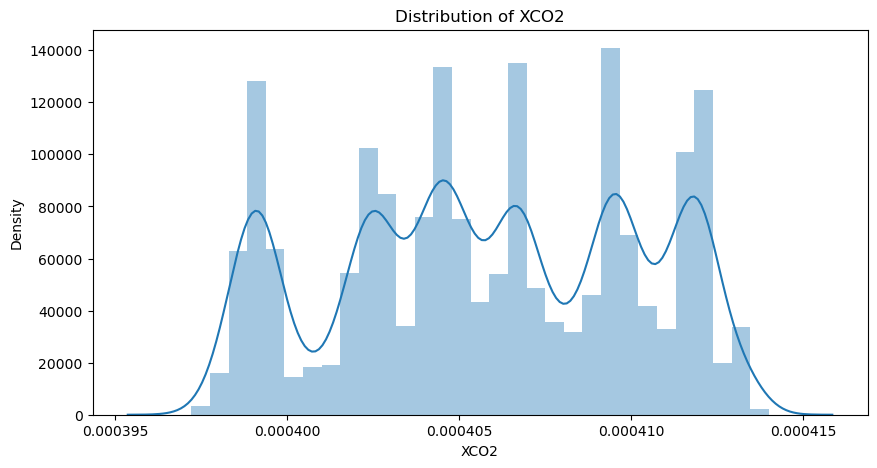

In [76]:
plt.rcParams["figure.figsize"] = (10,5)
sns.distplot(modelling_data["XCO2"])
plt.title("Distribution of XCO2")
plt.show()

### Separating dependent and Independent variables

In [77]:
X = modelling_data.drop(["XCO2"], axis=1)
y = modelling_data["XCO2"]

In [78]:
X.isna().sum()

Year            0
capacity_mw     0
plant_type      0
primary_fuel    0
population      0
frp             0
dtype: int64

In [79]:
X = pd.get_dummies(X)

### Splitting dataset for training data and testing data

taking 80% for training and 20% for testing

In [80]:
random_state = 42
X_train, X_test, y_train,y_test = train_test_split(X, y, random_state=random_state, test_size=.2)

In [81]:
print(f"Training size: {len(X_train)}\nTesting size: {len(X_test)}")

Training size: 13708
Testing size: 3428


In [82]:
## Training features "dataset
X_train.head()

,Year,capacity_mw,population,frp,plant_type_Cement,plant_type_NA,plant_type_Oil refineries,plant_type_Steel,primary_fuel_Geothermal,primary_fuel_Hydro,primary_fuel_NA,primary_fuel_Oil,primary_fuel_Wind
23105,2015,0.0,63108.188,0.00,0,1,0,0,0,0,1,0,0
13178,2019,225.0,401951.470,0.00,0,1,0,0,0,1,0,0,0
9338,2016,0.0,94557.420,0.00,0,1,0,0,0,0,1,0,0
16909,2017,0.0,2130543.000,114.56,0,1,0,0,0,0,1,0,0
13573,2019,0.0,41399.824,0.00,0,1,0,0,0,0,1,0,0


In [83]:
## Test features dataset
X_test.head()

,Year,capacity_mw,population,frp,plant_type_Cement,plant_type_NA,plant_type_Oil refineries,plant_type_Steel,primary_fuel_Geothermal,primary_fuel_Hydro,primary_fuel_NA,primary_fuel_Oil,primary_fuel_Wind
10340,2017,0.0,3223113.500,58.7,1,0,0,0,0,0,1,0,0
21105,2016,0.0,4580.005,0.0,0,1,0,0,0,0,1,0,0
12900,2020,20.0,1892152.800,0.0,0,1,0,0,0,1,0,0,0
11232,2020,0.0,629890.250,0.0,0,1,0,0,0,0,1,0,0
2587,2019,74.5,1336486.000,0.0,0,0,1,0,0,0,0,1,0


In [84]:
## Target training dataset
y_train.head()

23105    0.000399
13178    0.000408
9338     0.000403
16909    0.000405
13573    0.000409
Name: XCO2, dtype: float64

In [85]:
## Target test dataset
y_test.head()

10340    0.000404
21105    0.000402
12900    0.000412
11232    0.000411
2587     0.000410
Name: XCO2, dtype: float64

## Constructing the models

### Linear relationship and significance testing

In [86]:
ols_model_1 = sm.OLS(y_train, sm.add_constant(X_train))
osl_model_results_1 = ols_model_1.fit()

In [87]:
osl_model_results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   XCO2   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 5.128e+04
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:10:41   Log-Likelihood:             1.7548e+05
No. Observations:               13708   AIC:                        -3.509e+05
Df Residuals:                   13696   BIC:                        -3.509e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0032   4.65e-06   -688.846      0.000      -0.003      -0.003
Year                       2.504e-06   3.34e-09    748.767      0.000     2.5e-06    2.51e-06
capacity_mw                8.534e-11    2.8e-10      0.305      0.760   -4.63e-10    6.34e-10
population                -5.859e-14   1.09e-14     -5.368      0.000      -8e-14   -3.72e-14
frp                       -1.937e-09   2.77e-10     -7.006      0.000   -2.48e-09    -1.4e-09
plant_type_Cement            -0.0008   1.16e-06   -688.891      0.000      -0.001      -0.001
plant_type_NA                -0.0008   1.16e-06   -687.841      0.000      -0.001      -0.001
plant_type_Oil refineries    -0.0008   1.16e-06   -688.648      0.000      -0.001      -0.001
plant_type_Steel             -0.0008   1.16e-06   -688.550      0.000      -0.001      -0.001
primary_fuel_Geothermal      -0.0006    9.3e-07   -688.911      0.000      -0.001      -0.001
primary_fuel_Hydro           -0.0006    9.3e-07   -688.621      0.000      -0.001      -0.001
primary_fuel_NA              -0.0006   9.31e-07   -687.809      0.000      -0.001      -0.001
primary_fuel_Oil             -0.0006   9.32e-07   -687.581      0.000      -0.001      -0.001
primary_fuel_Wind            -0.0006   9.31e-07   -688.032      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      364.657   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.362
Skew:                           0.405   Prob(JB):                     2.32e-86
Kurtosis:                       3.186   Cond. No.                     2.20e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.63e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [88]:
y_test

10340    0.000404
21105    0.000402
12900    0.000412
11232    0.000411
2587     0.000410
           ...   
9182     0.000405
7774     0.000407
10321    0.000405
8455     0.000410
25406    0.000409
Name: XCO2, Length: 3428, dtype: float64

### Linear regression model 1

In [89]:
lr_model_1 = LinearRegression(fit_intercept=True)
lr_model_1.fit(X_train, y_train)

LinearRegression()

In [90]:
print(f"""
R2 score of linear regression: {lr_model_1.score(X_test, y_test)}\n
Mean square error of linear regression: {mean_squared_error(y_test, lr_model_1.predict(X_test))}""")


R2 score of linear regression: 0.9763746813775405

Mean square error of linear regression: 4.3626848656093907e-13


In [91]:
data = lr_model_1.coef_
labels = lr_model_1.feature_names_in_

In [101]:
lr_model_1.predict(X_test)

array([0.00040428, 0.00040214, 0.00041197, ..., 0.00040439, 0.00040964,
       0.00040714])

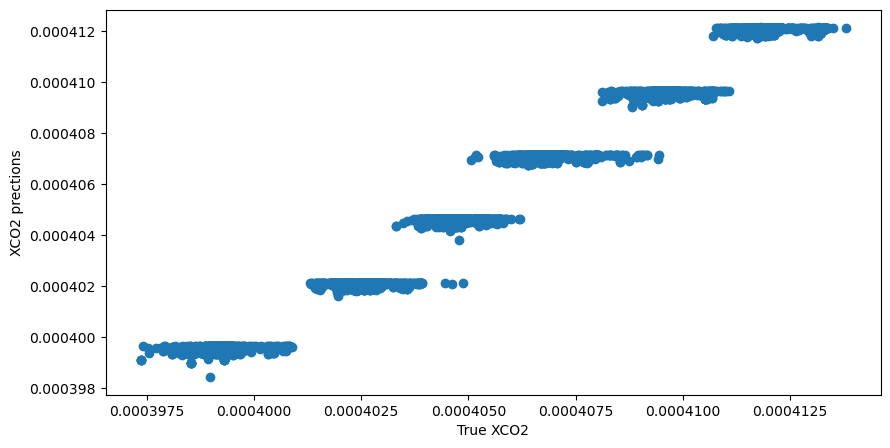

In [105]:
plt.scatter(y_test, lr_model_1.predict(X_test))
plt.ylabel("XCO2 prections")
plt.xlabel("True XCO2")
plt.show()

## Linear regression model 2

In [111]:
print("""COEFICIENCY OF FEATURES ON TARGET XCO2. 
      Positive indicate that the feature increases with the target\n
      Negative indicates that the feature decreases with target(XCO2)\n""")
for label, value in zip(labels, data):
    print(f"{label} has coefficient: { value }\n")

COEFICIENCY OF FEATURES ON TARGET XCO2. 
      Positive indicate that the feature increases with the target

      Negative indicates that the feature decreases with target(XCO2)

Year has coefficient: 2.503599372764867e-06

capacity_mw has coefficient: 8.53386408231511e-11

population has coefficient: -5.858791584075288e-14

frp has coefficient: -1.937479319697303e-09

plant_type_Cement  has coefficient: -2.367228762848735e-08

plant_type_NA has coefficient: 3.673377229651638e-08

plant_type_Oil refineries has coefficient: -3.282287957652758e-08

plant_type_Steel has coefficient: 1.9761394908498476e-08

primary_fuel_Geothermal has coefficient: -1.657255339507845e-07

primary_fuel_Hydro has coefficient: 2.0524001145623316e-08

primary_fuel_NA has coefficient: 9.530344832038059e-08

primary_fuel_Oil has coefficient: -3.4672036301250986e-08

primary_fuel_Wind has coefficient: 8.457012078603163e-08



## Observation and expalainability of the model

The model is able to explain/predict **97.63%** the XCO2 using year, capacity_mw, plant_type, primary_fuel, population and frp

Features with string(plant_type and primary_fuel) are encoded(one-hot encoding)

The year has high predicting power over othe features on XCO2

The data used is from 2015 to 2020


## Model without year among the features

In [112]:
X = modelling_data.drop(["XCO2", "Year"], axis=1)
y = modelling_data["XCO2"]
X = pd.get_dummies(X)
X_train, X_test, y_train,y_test = train_test_split(X, y, random_state=random_state, test_size=.2)


R2 score of linear regression: 0.004328196494697845

Mean square error of linear regression: 1.8386216828149503e-11


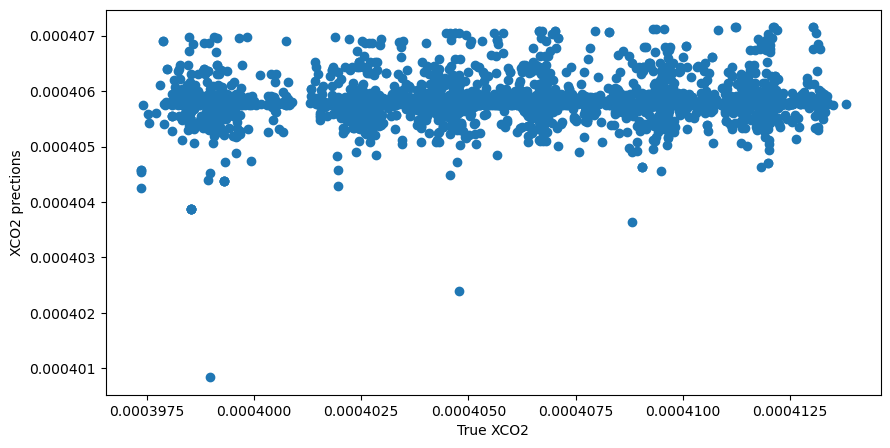

In [113]:
lr_model_2 = LinearRegression(fit_intercept=True)
lr_model_2.fit(X_train, y_train)

print(f"""
R2 score of linear regression: {lr_model_2.score(X_test, y_test)}\n
Mean square error of linear regression: {mean_squared_error(y_test, lr_model_2.predict(X_test))}""")

plt.scatter(y_test, lr_model_2.predict(X_test))
plt.ylabel("XCO2 prections")
plt.xlabel("True XCO2")
plt.show()